# Calibration


Import the necessary tools:

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

Create a class to do the calibration where the parameters of the calibratrion for the camera are calculated in a method and the images can be distortioned in other method.

In [25]:
class Calibration ():
    """
    Class that calibrates a camera by images of chessboards.
    """
    def __init__(self, imgsDirectoryGlob, nbVertical, nbHorizontal):
        """
        Method to instantiate the class.
            * Input:
            - imgsDirectory: this is the directory and regex expression to filter the files. 
                    Example: directory/right*.png
            - nbVertical: number of squares in the chessboard to look for in the vertical direction.
            - nbHorizontal: number of squares in the chessboard to look for in the horizontal direction.
        """
        self.imgsDirectoryGlob = imgsDirectoryGlob
        self.nbVertical = nbVertical
        self.nbHorizontal = nbHorizontal
        self.mtx = 0
        self.dist = 0
        self.calibrationDone = False
        self.calibrate()
    
    def calibrate (self):
        """
        Method that calculates the parameters of the calibration.
        """
        #############################################################
        # Definition of parameters
        #############################################################
        # Get parameters from attributes
        imgsDirectory = self.imgsDirectoryGlob
        nbVertical = self.nbVertical
        nbHorizontal = self.nbHorizontal
        
        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nbHorizontal*nbVertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nbVertical,0:nbHorizontal].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objPoints = [] # 3d point in real world space
        imgPoints = [] # 2d points in image plane.

        # Read the images in this directory
        images = glob.glob(imgsDirectory)
        assert images

        #############################################################
        # Get corners of chessboard
        #############################################################
        # Finish process if no images are found
        if len(images) == 0:        
            print("ERROR: No images found in this input: {}.".format(imgsDirectory))
            return -1, 0, 0

        # Continue otherwise
        # Read each image with this description and fit the chessboard squares
        numberCornersFound = 0
        for fname in images:
            # Make image to gray scale
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # findChessboardCorners
            ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)

            # If found, add object points, image points (after refining them)
            if ret == True:
                numberCornersFound += 1
                objPoints.append(objp)

                corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
                imgPoints.append(corners2)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners2, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

        cv2.destroyAllWindows()


        #############################################################
        # Compute calibration parameters
        #############################################################
        # Finish process if no corners are found
        if numberCornersFound == 0:
            print("ERROR: No corners fit in any chessboard image.")
            return -1, 0, 0

        # Otherwise continue
        # Compute the calibration parameters and show an example image if wanted
        print("Found {} number of corners.".format(numberCornersFound))

        # Calibrate
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
        
        # Update the class attributes
        self.mtx = mtx
        self.dist = dist
        self.calibrationDone = True

        return 0

    def undistortImage(self, imgPath):
        """
        Method that undistorts the image inputed by the parameters obtained by calibration.
        * Input parameters:
            - imgPath: path to the image to treat.
        """
        # Check if calibration is done
        if (self.calibrationDone == True):
            # Get parameters from class
            mtx = self.mtx
            dist = self.dist

            # Calibrate image as example
            sourceImg = cv2.imread(imgPath)
            sourceImgH,  sourceImgW = sourceImg.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (sourceImgW, sourceImgH), 1, (sourceImgW, sourceImgH))

            # Undistort
            dst = cv2.undistort(sourceImg, mtx, dist, None, newcameramtx)

            # crop the image
            x, y, w, h = roi
            dst = dst[y:y+h, x:x+w]
            
            # Resize? Is it better or worse? Remove lines and re-run everything if it does not work better.
            targetImgH, targetImgW = dst.shape[:2]
            targetImg = cv2.resize(dst, (sourceImgW, sourceImgH))
            
            # Plot images
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
            ax[0].imshow(sourceImg[...,[2,1,0]])
            ax[0].set_title('Original image')
            ax[1].imshow(targetImg[...,[2,1,0]])
            ax[1].set_title('Undistorted image')
            
            return 0
        else:
            print("ERROR: calibration needs to be done before.")
            return -1

    def undistortDirectoryIn(self, sourceDirectoryGlob, targetDirectory):
        """
        Method that undistorts the images that meet the glob string and .
        * Input parameters:
            - sourceDirectoryGlob: path to the images to treat, needs to define which pictures to call.
                    Example: directory/right*.png
            - targetDirectory: target directory where the files will be saved.
        """
        # Read the images in this directory
        images = glob.glob(sourceDirectoryGlob)
        assert images
        
        if not os.path.isdir(targetDirectory):
            os.mkdir(targetDirectory)

        for fname in images:
            # Get the name of the file
            filename = os.path.basename(fname)
            filenameTargetPath = os.path.join(targetDirectory, filename)
            
            # Get parameters from class
            mtx = self.mtx
            dist = self.dist

            # Calibrate image as example
            sourceImg = cv2.imread(fname)
            sourceImgH,  sourceImgW = sourceImg.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (sourceImgW, sourceImgH), 1, (sourceImgW, sourceImgH))

            # Undistort
            dst = cv2.undistort(sourceImg, mtx, dist, None, newcameramtx)

            # crop the image
            x, y, w, h = roi
            dst = dst[y:y+h, x:x+w]

            # Resize? Is it better or worse? Remove lines and re-run everything if it does not work better.
            targetImgH, targetImgW = dst.shape[:2]
            targetImg = cv2.resize(dst, (sourceImgW, sourceImgH))

            # Save image
            ## It saves it in the wrong color? WHY? I did not manage to fix it..
            targetImgColor = cv2.cvtColor(targetImg[...,[2,1,0]], cv2.COLOR_RGB2BGR)
            cv2.imwrite(filenameTargetPath, targetImgColor)

        return 0

## Right camera calibration
Create the method for the calibration of the right camera.

In [26]:
print("Right camera calibration:")
rightCalibration = Calibration('calibrationStereo/right*.png', 6, 8)

Right camera calibration:
Found 3 number of corners.


### Example 1
Example 1 for the calibration the right camera.

0

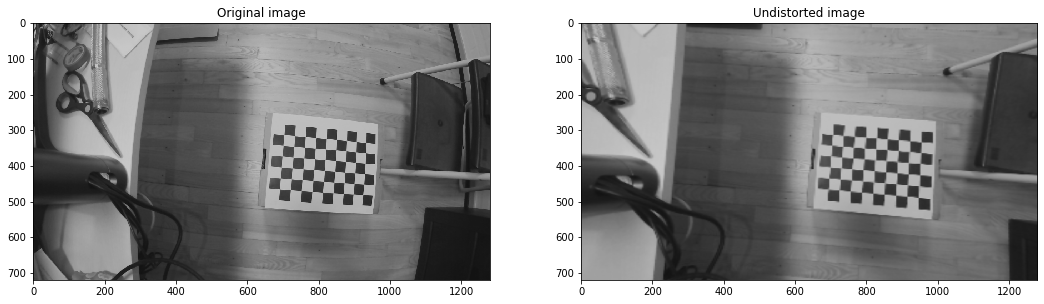

In [27]:
rightCalibration.undistortImage('calibrationStereo/right-0029.png')

### Example 2
Example 2 for the calibration the right camera.

0

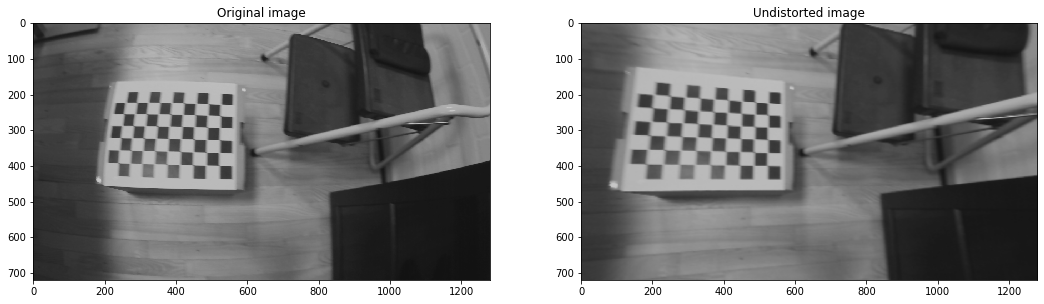

In [28]:
rightCalibration.undistortImage('calibrationStereo/right-0037.png')

## Left camera calibration
Create the method for the calibration of the right camera.

In [29]:
print("Left camera calibration:")
leftCalibration = Calibration('calibrationStereo/left*.png', 6, 6)

Left camera calibration:
Found 6 number of corners.


### Example 1
Example 1 for the calibration the left camera.

0

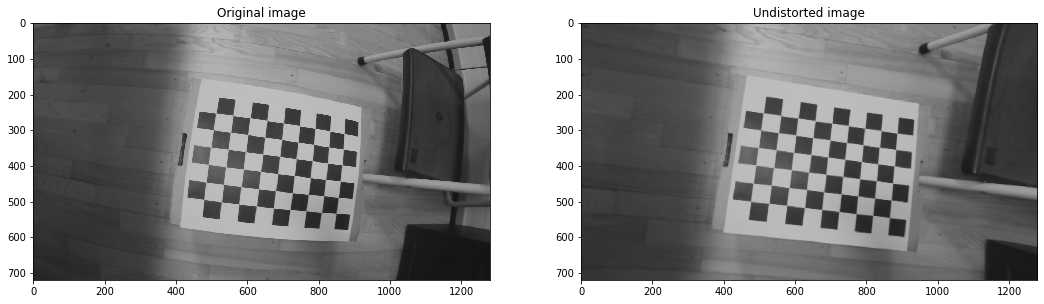

In [30]:
leftCalibration.undistortImage('calibrationStereo/left-0023.png')

### Example 2
Example 2 for the calibration the left camera.

0

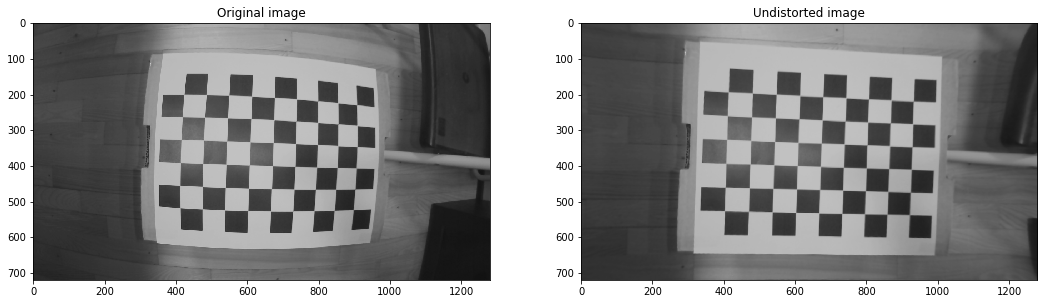

In [31]:
leftCalibration.undistortImage('calibrationStereo/left-0027.png')

0

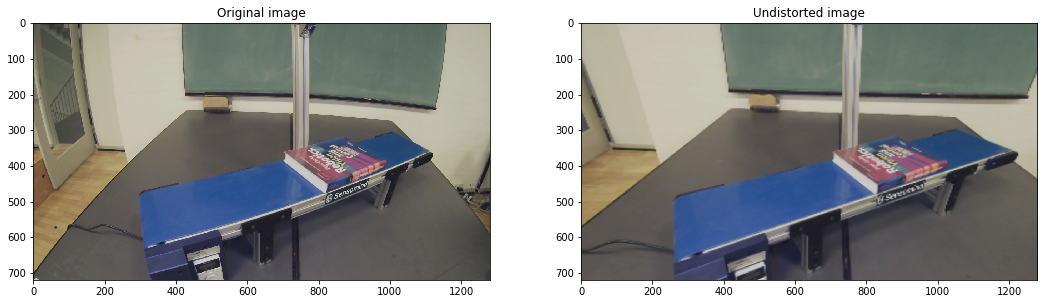

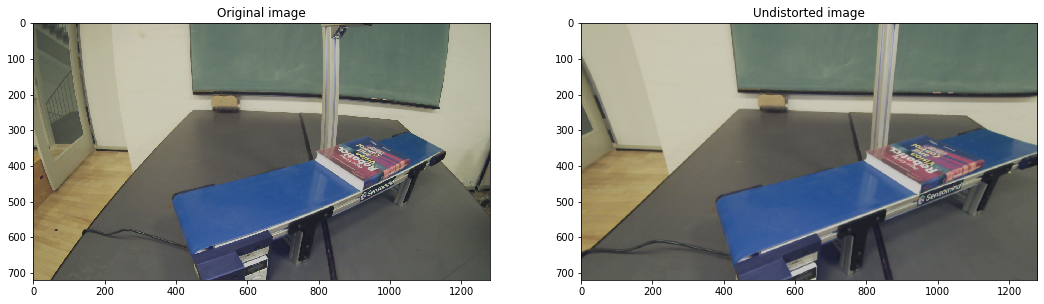

In [32]:
rightCalibration.undistortImage('imagesWithoutOcclusions/1585434311_201172113_Right.png')
leftCalibration.undistortImage('imagesWithoutOcclusions/1585434311_201172113_Left.png')

## Save undistorted images stereo camera
Save files of the right camera without occlussion undistorted.

In [33]:
rightCalibration.undistortDirectoryIn('imagesWithoutOcclusions/*Right.png', 'undistortedImagesWithoutOcclusion')

0

Save files of the left camera without occlussion undistorted.

In [34]:
leftCalibration.undistortDirectoryIn('imagesWithoutOcclusions/*Left.png', 'undistortedImagesWithoutOcclusion')

0

Save files of the right camera with occlussion undistorted.

In [35]:
rightCalibration.undistortDirectoryIn('imagesWithOcclusions/*Right.png', 'undistortedImagesWithOcclusion')

0

Save files of the left camera with occlussion undistorted.

In [ ]:
leftCalibration.undistortDirectoryIn('imagesWithOcclusions/*Left.png', 'undistortedImagesWithOcclusion')